In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Phase diagram of the Hubbard model with Mean Field Theory

More details on the formalism [here](https://arxiv.org/pdf/1403.2259.pdf).

We place ourselves at half filling ($\mu = \frac U 2$) and look for antiferromagnetic solutions ($m_{1} = - m_{2}$) assuming spatial homogeneity ($\langle n_{i,\alpha,\sigma} \rangle = \langle n_{\alpha,\sigma} \rangle$).

$\langle n_{\alpha, \sigma}\rangle$ is encoded in a vector:
\begin{pmatrix}
\langle n_{1, \uparrow}\rangle \\
\langle n_{1, \downarrow}\rangle \\
\langle n_{2, \uparrow}\rangle \\
\langle n_{2, \downarrow}\rangle \\
\end{pmatrix}

Among the 4 $\langle n_{\alpha, \sigma}\rangle$, only one is independant because of the assumptions. For $\alpha = 1,2$ we define:

\begin{cases}
\langle n_\alpha \rangle = \langle n_{\alpha, \uparrow} \rangle + \langle n_{\alpha, \downarrow} \rangle \\
\langle m_\alpha \rangle = \langle n_{\alpha, \uparrow} \rangle - \langle n_{\alpha, \downarrow} \rangle \\
\end{cases}

Then the assumptions lead to:

\begin{cases}
\langle n_1 \rangle = \langle n_2 \rangle = 1 \\
\langle m_1 \rangle = - \langle m_2 \rangle \\
\end{cases}

Therefore, the self-consistency equation can be written simply in terms of $m = \langle m_1 \rangle$ as $m = f(m)$. In practice, we compute $\langle n_{\alpha,\sigma} \rangle$ from $m$ with those constraints, and then use it to return $m$.


### $\vec k$ vectors

$\vec k$ vectors are denoted by integers $(h,l)$ such that $\vec k = \frac{\pi \sqrt 2}{L} (h \vec e_x + l \vec e_y)$ where $\vec e_x$ and $\vec e_y$ are unit vectors along $\vec b_1$ and $\vec b_2$ respectively. They are encoded by a vector of size 2 with components $h$ and $l$. With this notation, the first brillouin zone corresponds to integers $(h,l)$ verifying $|h| < \frac{\sqrt N} 2$ and $|l| < \frac{\sqrt N} 2$.

We have:

\begin{cases}
\vec k \cdot \vec b_1 = \frac{2 \pi h}{\sqrt N} \\
\vec k \cdot \vec b_2 = \frac{2 \pi l}{\sqrt N}
\end{cases}

### Spin

We encode $\sigma = \uparrow$ by `0` and $\sigma = \downarrow$ by `1`.

In [14]:
# Global parameters

# Distance between two atoms
a = 1

# Number of atoms (in the context of a unit cell with two atoms, the number of unit cells is N/2)
N = 100

# Hopping factor
t = 1

# Length of a side of the crystal assuming square crystal
L = a * N**0.5

# Brillouin zone
BZ = [[h,l] for h in range(-int(N**0.5 / 2), int(N**0.5 / 2)) for l in range(-int(N**0.5 / 2), int(N**0.5 / 2))]

In [59]:
def m1_to_nvec(m1):
    nvec = np.zeros(4)
    nvec[0] = (1 + m1) / 2
    nvec[1] = (1 - m1) / 2
    nvec[2] = (1 + m1) / 2 # - for AFM
    nvec[3] = (1 - m1) / 2 # + for AFM
    return nvec

In [60]:
# The matrix to diagonalize for a given k and spin
def cmat(nvec, k, sigma, U):
    
    h = k[0]
    l = k[1]
    
    gamma_k = - (1 + np.exp(-1.j * 2 * np.pi * (h + l) / N**0.5) + np.exp(-1.j * 2 * np.pi * h / N**0.5) + np.exp(-1.j * 2 * np.pi * l / N**0.5))
    
    M = np.zeros((2,2), dtype = complex)
    
    M[0,0] = U * nvec[1 - sigma]
    M[1,1] = U * nvec[3 - sigma]
    
    M[0,1] = t * gamma_k
    M[1,0] = t * np.conj(gamma_k)
    
    return M

In [61]:
# Returns nvec as a function of nvec
def occfunc(nvec, U, T):
    
    new_nvec = np.zeros(4, dtype = complex)
    
    # We start by computing all the eigenvectors and eigencoefficients for all k vectors and all spins
    for k in BZ:
        for sigma in [0, 1]:
            
            M = cmat(nvec, k, sigma, U)
            eigvals, eigvecs = np.linalg.eig(M)
            
            for alpha in [0, 1]:
                for j in [0, 1]:
                    new_nvec[2 * alpha + sigma] += abs(eigvecs[alpha, j])**2 / (1 + np.exp((eigvals[j] - U/2) / T))
            
    new_nvec = new_nvec / N # N/2 unit cells
    
    return new_nvec

In [62]:
# Returns m as a function of m
def mfunc(m, U, T):
    nvec = m1_to_nvec(m)
    nvec = occfunc(nvec, U, T)
    m = nvec[0] - nvec[1]
    if np.imag(m) > 0.00000001:
        print("Big Problem !!!")
    return np.real(m)

In [63]:
# Returns a fixed point of mfunc
def fixed_point(x0, U, T, iterations = 50):
    x1 = x0
    for k in range(iterations):
        x1, x0 = mfunc(x1, U, T), x1
    if abs(x1 - x0) > 1e-2:
        print("Maybe not convergence:")
        print(x1, x0)
    return x1

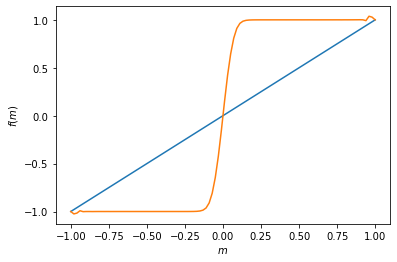

In [67]:
U = 100
T = 1

x = np.linspace(-1, 1, 100)
y = []
for m in x:
    y.append(mfunc(m, U, T))

plt.plot(x,x)
plt.plot(x,y)

plt.xlabel('$m$')
plt.ylabel('$f(m)$')

print()

In [68]:
fixed_point(1, U, T)

1.0

In [27]:
# The phase diagramm

PM_U = []
PM_T = []

AFM_U = []
AFM_T = []

eps = 1e-5

for U in np.linspace(0.01, 2, 30):
    for T in np.linspace(0.01, 0.7, 30):
        m = fixed_point(0.5, U, T)
        if m > eps:
            AFM_U.append(U)
            AFM_T.append(T)
        elif - eps < m < eps:
            PM_U.append(U)
            PM_T.append(T)
        else:
            print("Problemooo")

plt.scatter(PM_U, PM_T, s = 100, c = 'r')
plt.scatter(AFM_U, AFM_T, s = 100, c = 'b')

plt.xlabel('$U$')
plt.ylabel('$T$')
print()

KeyboardInterrupt: 

Maybe not convergence:
0.007705842569145194 -0.008085096721623497
Maybe not convergence:
0.013547101997159472 -0.01086010698535922
Maybe not convergence:
0.011110229280265393 -0.005245039472319024
Maybe not convergence:
-0.006629049019398647 0.004628379987788089
Maybe not convergence:
0.0038203807777926757 -0.02037335215666697
Maybe not convergence:
-0.000469923114080506 -0.011484573592371095
Maybe not convergence:
0.018563293841536266 0.007183901469195619
Maybe not convergence:
-0.0012004808610944773 0.00919075737009184
Maybe not convergence:
-0.001373723770238089 0.012914613744527292
Maybe not convergence:
0.005123893884828812 -0.007184500578299113
Maybe not convergence:
-0.009304606560322615 0.0017597902350305894
Maybe not convergence:
-0.002885870568212101 0.009985426822270882
Maybe not convergence:
-0.00958538959347155 -0.027503392342976052
Maybe not convergence:
-0.00019312163173251795 -0.014159238001824836
Maybe not convergence:
-0.0010194911377225946 0.014508118287433092
Maybe 

Maybe not convergence:
0.8828297813667312 0.8970276439335123
Maybe not convergence:
0.9891364843633325 1.0040660190246105
Maybe not convergence:
0.977332536879198 0.9963218688373858
Maybe not convergence:
0.9525204541835278 0.9643547753080014
Maybe not convergence:
0.9171771814382678 0.929286205290182



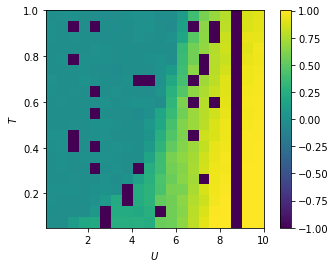

In [76]:
# The magnetization as a function of (U,T)

eps = 1e-5

npoint = 20
U_l = np.linspace(0.1, 10, npoint)
T_l = np.linspace(0.05, 1, npoint)

MMat = np.zeros((len(U_l), len(T_l)))

for j, U in enumerate(U_l):
    for i, T in enumerate(T_l):
        try:
            m = fixed_point(0.5, U, T)
        except np.linalg.LinAlgError:
            m = -1
        MMat[i,j] = m

extent = [U_l[0], U_l[-1], T_l[0], T_l[-1]]
aspect = (U_l[-1] - U_l[0]) / (T_l[-1] - T_l[0])
plt.imshow(MMat, extent = extent, aspect = aspect, origin = 'lower')
plt.colorbar()

plt.xlabel('$U$')
plt.ylabel('$T$')
print()